EE initialized with project: earth-engine-project-470617
Beginning daily export loop for Uttarakhand...
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-09.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-10.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-11.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-12.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-13.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-14.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-15.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-16.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-17.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-18.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-19.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2016-04-20.tif
Stack exists, skipping: daily_stacks\Uttarakhand_stack_2

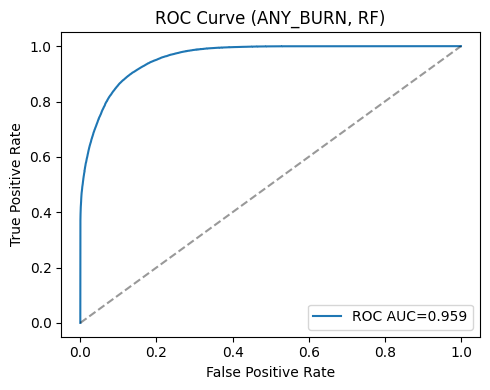

Saved: figures\eval_roc_anyburn_rf.png


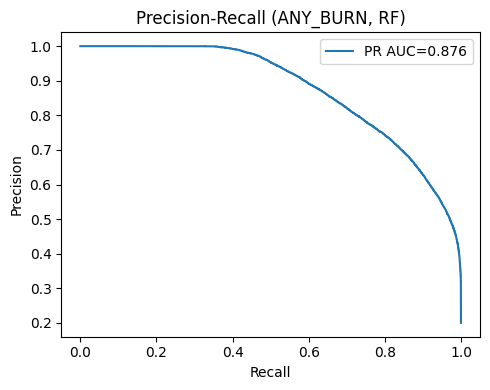

Saved: figures\eval_pr_anyburn_rf.png


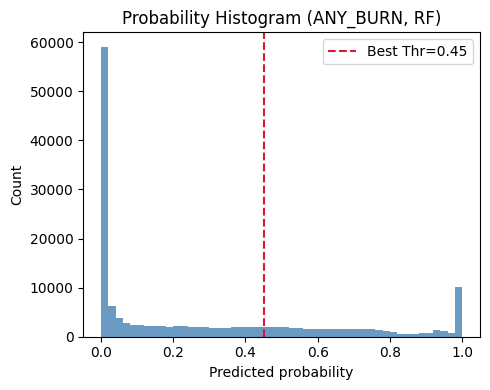

Saved: figures\eval_hist_anyburn_rf.png
Saved model -> models\anyburn_rf_best.joblib
Saved metrics JSON -> figures\eval_metrics_anyburn_rf.json


In [ ]:
import os, glob, json
from datetime import datetime, timedelta

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    f1_score, accuracy_score,
)

import ee, geemap
PROJECT_ID = 'earth-engine-project-470617'

try:
    ee.Initialize(project=PROJECT_ID)
except Exception:
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)
print('EE initialized with project:', PROJECT_ID)

UTTARAKHAND_GEOM = ee.Geometry.Rectangle([77.5, 28.7, 81.5, 31.3])

START_DATE = '2016-04-09'
END_DATE   = '2016-06-15'

OUTPUT_DIR_STACKS = 'daily_stacks'
os.makedirs(OUTPUT_DIR_STACKS, exist_ok=True)

DO_EXPORT_FROM_GEE = True   

LAG_DAYS        = 3       
NEG_PER_POS     = 4       
POS_CAP_PER_DAY = 3000     
DILATE_LABELS   = True    
RANDOM_STATE    = 42

FIG_DIR   = 'figures'
MODEL_DIR = 'models'
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

if DO_EXPORT_FROM_GEE:
    print('Beginning daily export loop for Uttarakhand...')
    scale = 500
    crs = 'EPSG:4326'

    lulc = ee.ImageCollection('ESA/WorldCover/v100').first().select('Map').rename('LULC').clip(UTTARAKHAND_GEOM)
    dem = ee.Image('USGS/SRTMGL1_003').clip(UTTARAKHAND_GEOM).rename('DEM')
    terrain = ee.Terrain.products(dem)
    slope = terrain.select('slope').rename('Slope')
    aspect = terrain.select('aspect').rename('Aspect')
    hillshade = ee.Terrain.hillshade(dem).rename('Hillshade')

    era5 = ee.ImageCollection('ECMWF/ERA5/DAILY')
    ndvi_ic = ee.ImageCollection('MODIS/061/MOD13Q1').select('NDVI')
    burn_ic = ee.ImageCollection('MODIS/061/MCD64A1').select('BurnDate')

    start_dt = datetime.strptime(START_DATE, '%Y-%m-%d')
    end_dt   = datetime.strptime(END_DATE, '%Y-%m-%d')
    cur = start_dt
    while cur <= end_dt:
        dstr = cur.strftime('%Y-%m-%d')
        day  = ee.Date(dstr)

        temp = era5.filterDate(day, day.advance(1,'day')).select('mean_2m_air_temperature').mean().add(-273.15).rename('TempC')
        u    = era5.filterDate(day, day.advance(1,'day')).select('u_component_of_wind_10m').mean().rename('U10')
        v    = era5.filterDate(day, day.advance(1,'day')).select('v_component_of_wind_10m').mean().rename('V10')
        wspd = u.pow(2).add(v.pow(2)).sqrt().rename('WindSpeed')
        ndvi = ndvi_ic.filterDate(day.advance(-16,'day'), day.advance(1,'day')).mean().multiply(0.0001).rename('NDVI')
        burn = burn_ic.filterDate(day.advance(-32,'day'), day.advance(1,'day')).mosaic().rename('BurnDate')

        daily_stack = temp.addBands([u, v, wspd, ndvi, burn, lulc, dem, slope, aspect, hillshade])
        out_stack_path = os.path.join(OUTPUT_DIR_STACKS, f'Uttarakhand_stack_{dstr}.tif')

        if os.path.exists(out_stack_path):
            print('Stack exists, skipping:', out_stack_path)
        else:
            print('Exporting stacked image for', dstr)
            try:
                geemap.ee_export_image(
                    daily_stack,
                    filename=out_stack_path,
                    region=UTTARAKHAND_GEOM,
                    scale=scale,
                    crs=crs,
                    file_per_band=False,
                )
            except Exception as e:
                print('Export failed for', dstr, '->', e)
        cur += timedelta(days=1)
    print('Daily exports complete.')
else:
    print('Skipping GEE export (DO_EXPORT_FROM_GEE=False). Using existing stacks in', OUTPUT_DIR_STACKS)

pattern = os.path.join(OUTPUT_DIR_STACKS, 'Uttarakhand_stack_*.tif')
stack_files = sorted(glob.glob(pattern))
if not stack_files:
    raise SystemExit('No stacked files found in ' + OUTPUT_DIR_STACKS + '. Run export section first.')

stack_list = []
dates = []
for f in stack_files:
    dates.append(os.path.basename(f).split('_')[-1].replace('.tif',''))
    with rasterio.open(f) as src:
        arr = src.read().astype('float32')  
    if arr.ndim != 3:
        raise RuntimeError('Unexpected array shape in ' + f)
    stack_list.append(arr)

stack = np.stack(stack_list, axis=0)  
T, B, H, W = stack.shape
print('Loaded stack shape:', stack.shape, '| Days:', len(dates))

B_TEMP, B_U, B_V, B_WS, B_NDVI, B_BURN = 0, 1, 2, 3, 4, 5
B_LULC, B_DEM, B_SLOPE, B_ASPECT, B_HILL = 6, 7, 8, 9, 10

DYN_BASE_IDXS = [B_TEMP, B_U, B_V, B_WS, B_NDVI]
STATIC_IDXS   = [B_LULC, B_DEM, B_SLOPE, B_ASPECT, B_HILL]

rng = np.random.RandomState(RANDOM_STATE)
structure = np.ones((3, 3), dtype=bool) if DILATE_LABELS else None

def build_anyburn_dataset(stack, lag_days, neg_per_pos, pos_cap_per_day, dilate_labels=True):
    T, B, H, W = stack.shape
    X_list = []
    y_list = []
    total_pos = 0
    total_neg = 0
    for t in range(lag_days - 1, T - 1): 
        burn_now  = (stack[t,   B_BURN] > 0).astype('uint8')
        burn_next = (stack[t+1, B_BURN] > 0).astype('uint8')

        if dilate_labels and burn_next.any():
            burn_next = binary_dilation(burn_next, structure=structure).astype('uint8')

        ys_pos, xs_pos = np.where(burn_next == 1)
        n_pos = ys_pos.size
        if n_pos == 0:
            continue
        if n_pos > pos_cap_per_day:
            sel = rng.choice(np.arange(n_pos), size=pos_cap_per_day, replace=False)
            ys_pos = ys_pos[sel]
            xs_pos = xs_pos[sel]
            n_pos = pos_cap_per_day

        ys_neg, xs_neg = np.where(burn_next == 0)
        if ys_neg.size == 0:
            continue
        n_neg_target = min(ys_neg.size, neg_per_pos * n_pos)
        sel_neg = rng.choice(np.arange(ys_neg.size), size=n_neg_target, replace=False)
        ys_neg = ys_neg[sel_neg]
        xs_neg = xs_neg[sel_neg]
        n_neg = n_neg_target

        ys_all = np.concatenate([ys_pos, ys_neg])
        xs_all = np.concatenate([xs_pos, xs_neg])
        labels = np.concatenate([np.ones(n_pos, dtype='uint8'), np.zeros(n_neg, dtype='uint8')])

        feats_dyn = []
        for li in range(lag_days):
            tt = t - li
            if tt < 0:
                continue
            dyn_slice = stack[tt, DYN_BASE_IDXS][:, ys_all, xs_all] 
            feats_dyn.append(dyn_slice)
        if not feats_dyn:
            continue
        dyn_all = np.concatenate(feats_dyn, axis=0)  

        static_slice = stack[t, STATIC_IDXS][:, ys_all, xs_all]  
        burn_now_feat = burn_now[ys_all, xs_all][None, :].astype('float32')  

        x_t = np.concatenate([dyn_all, static_slice, burn_now_feat], axis=0).T  
        X_list.append(x_t.astype('float32'))
        y_list.append(labels)

        total_pos += n_pos
        total_neg += n_neg
    if not X_list:
        raise SystemExit('No samples collected. Check date range and burn data.')
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    print('Tabular dataset built: ', X_all.shape, '| positives:', int((y_all == 1).sum()), 'negatives:', int((y_all == 0).sum()))
    print('Positive ratio:', float(y_all.mean()))
    return X_all, y_all

X_all, y_all = build_anyburn_dataset(stack, LAG_DAYS, NEG_PER_POS, POS_CAP_PER_DAY, DILATE_LABELS)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
)
print('Train:', X_train.shape, 'Test:', X_test.shape)

RF_PARAMS = dict(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced_subsample',
    max_samples=0.6,
    random_state=RANDOM_STATE,
 )

rf = RandomForestClassifier(**RF_PARAMS)
rf.fit(X_train, y_train)
print('Random Forest trained.')

probs = rf.predict_proba(X_test)[:, 1].astype('float32')
probs = np.nan_to_num(probs, nan=0.0, posinf=1.0, neginf=0.0)
probs = np.clip(probs, 0.0, 1.0)

roc_auc = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else float('nan')
pr_auc  = average_precision_score(y_test, probs) if len(np.unique(y_test)) > 1 else float('nan')
print(f'ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}')

def confusion_metrics(y_true, y_pred):
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    gmean = (sens * spec) ** 0.5 if sens > 0 and spec > 0 else 0.0
    cba_pos = tp / max(tp + fp, tp + fn) if (tp + fp) > 0 or (tp + fn) > 0 else 0.0
    cba_neg = tn / max(tn + fn, tn + fp) if (tn + fn) > 0 or (tn + fp) > 0 else 0.0
    cba = 0.5 * (cba_pos + cba_neg)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    return dict(tp=tp, tn=tn, fp=fp, fn=fn, sensitivity=sens, specificity=spec, gmean=gmean, cba=cba, precision=prec, accuracy=acc)

thr_default = 0.5
y_pred_05 = (probs >= thr_default).astype('uint8')
metrics_05 = confusion_metrics(y_test, y_pred_05)

ths = np.linspace(0.05, 0.95, 19)
best_thr = thr_default
best_metrics = metrics_05
best_g = best_metrics['gmean']
for th in ths:
    y_pred = (probs >= th).astype('uint8')
    m = confusion_metrics(y_test, y_pred)
    if m['gmean'] > best_g:
        best_g = m['gmean']
        best_thr = float(th)
        best_metrics = m

print('\nMetrics at threshold 0.5:')
for k, v in metrics_05.items():
    if isinstance(v, float):
        print(f'  {k}: {v:.4f}')
    else:
        print(f'  {k}: {v}')

print(f"\nBest threshold by G-mean: {best_thr:.3f}")
print('Metrics at best threshold:')
for k, v in best_metrics.items():
    if isinstance(v, float):
        print(f'  {k}: {v:.4f}')
    else:
        print(f'  {k}: {v}')

suffix = 'anyburn_rf'

try:
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (ANY_BURN, RF)')
    plt.legend()
    out_png = os.path.join(FIG_DIR, f'eval_roc_{suffix}.png')
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    print('Saved:', out_png)
except Exception as e:
    print('ROC plot skipped:', e)

try:
    prec, rec, _ = precision_recall_curve(y_test, probs)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, label=f'PR AUC={pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (ANY_BURN, RF)')
    plt.legend()
    out_png = os.path.join(FIG_DIR, f'eval_pr_{suffix}.png')
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    print('Saved:', out_png)
except Exception as e:
    print('PR plot skipped:', e)

plt.figure(figsize=(5, 4))
plt.hist(probs, bins=50, range=(0, 1), color='steelblue', alpha=0.8)
plt.axvline(best_thr, color='crimson', linestyle='--', label=f'Best Thr={best_thr:.2f}')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.title('Probability Histogram (ANY_BURN, RF)')
plt.legend()
out_png = os.path.join(FIG_DIR, f'eval_hist_{suffix}.png')
plt.tight_layout()
plt.savefig(out_png, dpi=150)
plt.show()
print('Saved:', out_png)

try:
    import joblib
    model_path = os.path.join(MODEL_DIR, f'{suffix}_best.joblib')
    joblib.dump({'model': rf, 'best_threshold': best_thr, 'roc_auc': roc_auc, 'pr_auc': pr_auc}, model_path)
    print('Saved model ->', model_path)
except Exception as e:
    print('Saving model bundle failed:', e)

metrics_payload = {
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc),
    'threshold_default': float(thr_default),
    'metrics_default': metrics_05,
    'threshold_best_gmean': float(best_thr),
    'metrics_best_gmean': best_metrics,
}
try:
    json_path = os.path.join(FIG_DIR, f'eval_metrics_{suffix}.json')
    with open(json_path, 'w') as f:
        json.dump(metrics_payload, f, indent=2)
    print('Saved metrics JSON ->', json_path)
except Exception as e:
    print('Saving metrics JSON failed:', e)

In [ ]:
import numpy as np

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers



PATCH_SIZE = 128        

LEAD_DAYS = 1      

MAX_POS_PATCHES = 800   

NEG_PER_POS_PATCH = 2   

VAL_SPLIT = 0.15

TEST_SPLIT = 0.15

RANDOM_STATE_DL = 123

DILATE_LABELS_DL = True  



rng_dl = np.random.RandomState(RANDOM_STATE_DL)



UNET_FEATURE_IDXS = [B_TEMP, B_U, B_V, B_WS, B_NDVI,

                     B_LULC, B_DEM, B_SLOPE, B_ASPECT, B_HILL]



from scipy.ndimage import binary_dilation as _binary_dilation_unet



def _extract_patch_hw(img_hw, cy, cx, size):

    """Extract a square patch [size x size] around (cy, cx) from a 2D array with zero padding if needed."""

    half = size // 2

    y0 = cy - half

    x0 = cx - half

    y1 = y0 + size

    x1 = x0 + size

    H, W = img_hw.shape



    pad_top = max(0, -y0)

    pad_left = max(0, -x0)

    pad_bottom = max(0, y1 - H)

    pad_right = max(0, x1 - W)



    if pad_top or pad_left or pad_bottom or pad_right:

        img_padded = np.pad(img_hw,

                            ((pad_top, pad_bottom), (pad_left, pad_right)),

                            mode='constant', constant_values=0)

        y0_p = y0 + pad_top

        x0_p = x0 + pad_left

        patch = img_padded[y0_p:y0_p+size, x0_p:x0_p+size]

    else:

        patch = img_hw[y0:y1, x0:x1]

    return patch



def _extract_patch_chw(img_chw, cy, cx, size):

    """Extract patch [C, H, W] -> [size, size, C] with padding."""

    C, H, W = img_chw.shape

    patch_list = []

    for c in range(C):

        p = _extract_patch_hw(img_chw[c], cy, cx, size)

        patch_list.append(p)

    patch_chw = np.stack(patch_list, axis=0) 

    return np.transpose(patch_chw, (1, 2, 0))  



def build_unet_patches(stack, lead_days=1, max_pos_patches=800, neg_per_pos=2,

                        patch_size=128, dilate_labels=True):


    T, B, H, W = stack.shape

    structure = np.ones((3, 3), dtype=bool) if dilate_labels else None



    X_patches = []

    Y_patches = []



    total_pos_patches = 0



    for t in range(0, T - lead_days):

        burn_future = (stack[t + lead_days, B_BURN] > 0).astype('uint8')

        if dilate_labels and burn_future.any():

            burn_future = _binary_dilation_unet(burn_future, structure=structure).astype('uint8')



        ys_pos, xs_pos = np.where(burn_future == 1)

        if ys_pos.size == 0:

            continue


        n_pos_day = ys_pos.size

        max_pos_per_day = max(1, max_pos_patches // max(1, (T - lead_days)))

        if n_pos_day > max_pos_per_day:

            sel = rng_dl.choice(np.arange(n_pos_day), size=max_pos_per_day, replace=False)

            ys_pos = ys_pos[sel]

            xs_pos = xs_pos[sel]


        feat_chw = stack[t, UNET_FEATURE_IDXS] 


        for cy, cx in zip(ys_pos, xs_pos):

            if total_pos_patches >= max_pos_patches:

                break

            y_patch = _extract_patch_hw(burn_future, cy, cx, patch_size).astype('float32')

            if y_patch.max() == 0: 

                continue

            x_patch = _extract_patch_chw(feat_chw, cy, cx, patch_size)

            X_patches.append(x_patch)

            Y_patches.append(y_patch[..., None])  

            total_pos_patches += 1

        if total_pos_patches >= max_pos_patches:

            break




        ys_neg, xs_neg = np.where(burn_future == 0)

        if ys_neg.size > 0 and ys_pos.size > 0:

            n_neg_target = min(ys_neg.size, neg_per_pos * ys_pos.size)

            seln = rng_dl.choice(np.arange(ys_neg.size), size=n_neg_target, replace=False)

            ys_neg = ys_neg[seln]

            xs_neg = xs_neg[seln]

            for cy, cx in zip(ys_neg, xs_neg):

                y_patch = _extract_patch_hw(burn_future, cy, cx, patch_size).astype('float32')

                if y_patch.max() != 0: 

                    continue

                x_patch = _extract_patch_chw(feat_chw, cy, cx, patch_size)

                X_patches.append(x_patch)

                Y_patches.append(y_patch[..., None])



    if not X_patches:

        raise SystemExit('No U-Net patches collected. Check date range and burn data.')



    X_arr = np.stack(X_patches, axis=0).astype('float32')

    Y_arr = np.stack(Y_patches, axis=0).astype('float32')

    print('U-Net patch dataset:', X_arr.shape, 'Pos-pixel ratio:', float(Y_arr.mean()))

    return X_arr, Y_arr


X_patches, Y_patches = build_unet_patches(

    stack,

    lead_days=LEAD_DAYS,

    max_pos_patches=MAX_POS_PATCHES,

    neg_per_pos=NEG_PER_POS_PATCH,

    patch_size=PATCH_SIZE,

    dilate_labels=DILATE_LABELS_DL,

)


from sklearn.model_selection import train_test_split as _tt_split



X_train_u, X_tmp_u, Y_train_u, Y_tmp_u = _tt_split(

    X_patches, Y_patches, test_size=(VAL_SPLIT + TEST_SPLIT),

    random_state=RANDOM_STATE_DL, shuffle=True,

)



rel_test = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)

X_val_u, X_test_u, Y_val_u, Y_test_u = _tt_split(

    X_tmp_u, Y_tmp_u, test_size=rel_test,

    random_state=RANDOM_STATE_DL, shuffle=True,

)



print('U-Net Train:', X_train_u.shape, 'Val:', X_val_u.shape, 'Test:', X_test_u.shape)



ALPHA_FOCAL = 0.25   

GAMMA_FOCAL = 2.0



def binary_focal_loss(alpha=ALPHA_FOCAL, gamma=GAMMA_FOCAL):

    def loss_fn(y_true, y_pred):

        y_true = tf.cast(y_true, tf.float32)

        y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0 - 1e-6)

        ce = -(y_true * tf.math.log(y_pred) + (1.0 - y_true) * tf.math.log(1.0 - y_pred))

        pt = tf.where(tf.equal(y_true, 1.0), y_pred, 1.0 - y_pred)

        w = alpha * tf.pow(1.0 - pt, gamma)

        return tf.reduce_mean(w * ce)

    return loss_fn


def build_unet(input_shape, base_filters=(32, 64, 128), dropout_values=(0.05, 0.1, 0.15)):

    inputs = keras.Input(shape=input_shape)



    x = inputs

    skips = []

    for i, f in enumerate(base_filters):

        x = layers.Conv2D(f, (3, 3), padding='same', activation='relu')(x)

        if dropout_values and i < len(dropout_values):

            x = layers.Dropout(dropout_values[i])(x)

        x = layers.Conv2D(f, (3, 3), padding='same', activation='relu')(x)

        skips.append(x)

        x = layers.MaxPooling2D((2, 2))(x)


    b = base_filters[-1] * 2

    x = layers.Conv2D(b, (3, 3), padding='same', activation='relu')(x)

    x = layers.Conv2D(b, (3, 3), padding='same', activation='relu')(x)



    for i, f in reversed(list(enumerate(base_filters))):

        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(x)

        x = layers.Concatenate()([x, skips[i]])

        x = layers.Conv2D(f, (3, 3), padding='same', activation='relu')(x)

        x = layers.Conv2D(f, (3, 3), padding='same', activation='relu')(x)



    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='unet_nextday_single')

    return model



input_shape = (PATCH_SIZE, PATCH_SIZE, X_patches.shape[-1])

unet_model = build_unet(input_shape)

unet_model.compile(

    optimizer=keras.optimizers.Adam(learning_rate=1e-4),

    loss=binary_focal_loss(),

    metrics=['accuracy'],

)



unet_model.summary()



callbacks = [

    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

]



history = unet_model.fit(

    X_train_u, Y_train_u,

    validation_data=(X_val_u, Y_val_u),

    epochs=100,

    batch_size=4,

    callbacks=callbacks,

    verbose=1,

)



Y_pred_test = unet_model.predict(X_test_u, batch_size=4)

Y_pred_probs = Y_pred_test.astype('float32').ravel()

Y_true_flat = Y_test_u.astype('float32').ravel()

Y_pred_probs = np.nan_to_num(Y_pred_probs, nan=0.0, posinf=1.0, neginf=0.0)

Y_pred_probs = np.clip(Y_pred_probs, 0.0, 1.0)



thr_default_u = 0.5

y_pred_bin_05 = (Y_pred_probs >= thr_default_u).astype('uint8')

metrics_unet_05 = confusion_metrics(Y_true_flat.astype('uint8'), y_pred_bin_05)



ths_u = np.linspace(0.05, 0.95, 19)

best_thr_u = thr_default_u

best_metrics_u = metrics_unet_05

best_g_u = best_metrics_u['gmean']

for th in ths_u:

    yb = (Y_pred_probs >= th).astype('uint8')

    m = confusion_metrics(Y_true_flat.astype('uint8'), yb)

    if m['gmean'] > best_g_u:

        best_g_u = m['gmean']

        best_thr_u = float(th)

        best_metrics_u = m



print('\n[U-Net Scenario 1] Metrics at threshold 0.5:')

for k, v in metrics_unet_05.items():

    if isinstance(v, float):

        print(f'  {k}: {v:.4f}')

    else:

        print(f'  {k}: {v}')



print(f"\n[U-Net Scenario 1] Best threshold by G-mean: {best_thr_u:.3f}")

print('[U-Net Scenario 1] Metrics at best threshold:')

for k, v in best_metrics_u.items():

    if isinstance(v, float):

        print(f'  {k}: {v:.4f}')

    else:

        print(f'  {k}: {v}')


U-Net patch dataset: (1014, 128, 128, 10) Pos-pixel ratio: 0.06753504276275635
U-Net Train: (709, 128, 128, 10) Val: (152, 128, 128, 10) Test: (153, 128, 128, 10)


Model: "unet_nextday_single"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,912 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 1,927,617 (7.35 MB)

 Trainable params: 1,927,617 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 128s 656ms/step - accuracy: 0.8788 - loss: 0.2621 - val_accuracy: 0.9284 - val_loss: 0.1470
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 140s 789ms/step - accuracy: 0.8858 - loss: 0.0933 - val_accuracy: 0.9289 - val_loss: 0.0601
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 71s 399ms/step - accuracy: 0.8946 - loss: 0.0374 - val_accuracy: 0.9229 - val_loss: 0.0202
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 63s 354ms/step - accuracy: 0.9062 - loss: 0.0232 - val_accuracy: 0.9329 - val_loss: 0.0204
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 386ms/step - accuracy: 0.9161 - loss: 0.0185 - val_accuracy: 0.9328 - val_loss: 0.0163
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 384ms/step - accuracy: 0.9208 - loss: 0.0165 - val_accuracy: 0.9320 - val_loss: 0.0141
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.9228 - loss: 0.0153 - val_accuracy: 0.9334 - val_loss: 0.0143
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 71s 397ms/step - accuracy: 0.9252

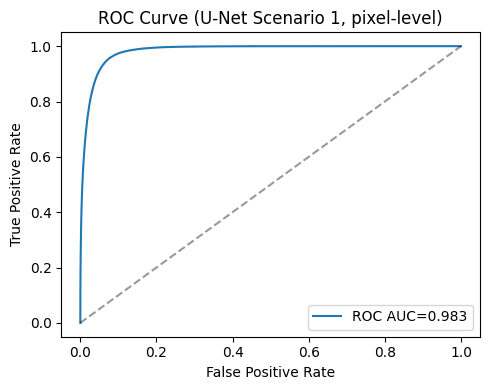

Saved ROC figure -> figures\eval_roc_unet_scenario1.png


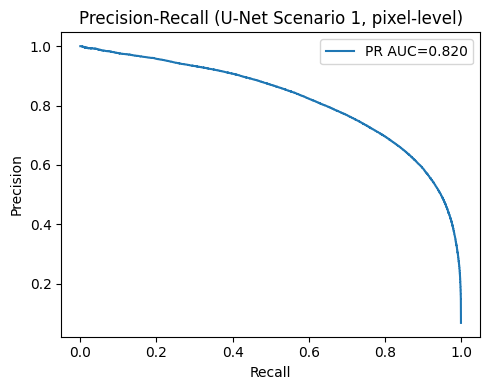

Saved PR figure -> figures\eval_pr_unet_scenario1.png


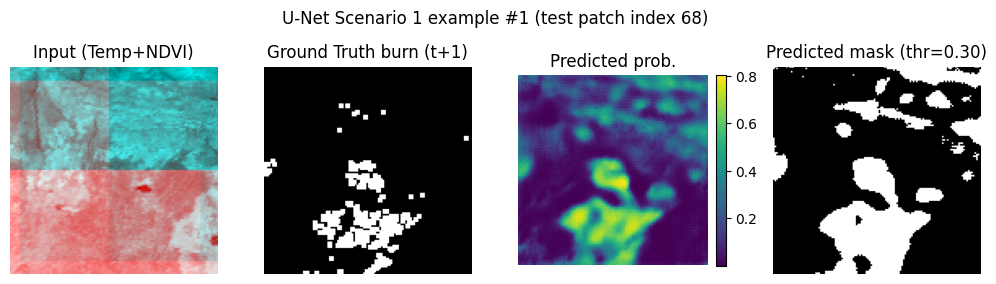

Saved example figure -> figures\unet_scenario1_example_1.png


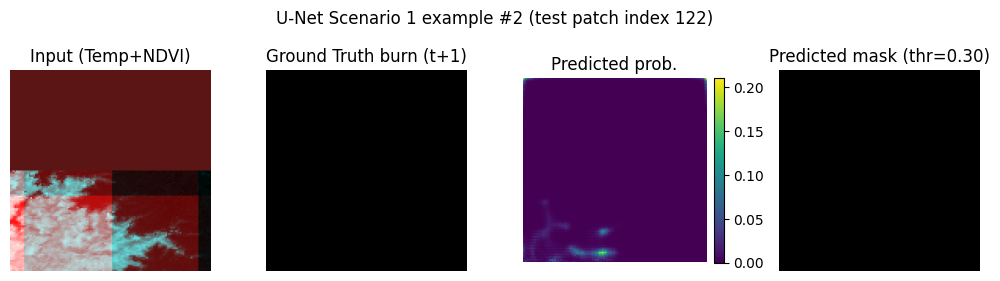

Saved example figure -> figures\unet_scenario1_example_2.png


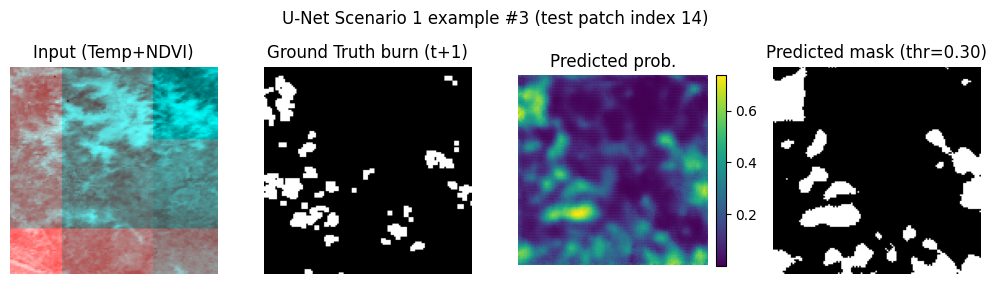

Saved example figure -> figures\unet_scenario1_example_3.png


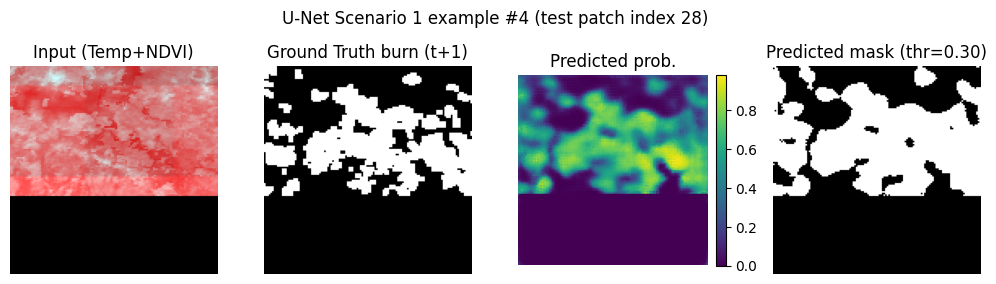

Saved example figure -> figures\unet_scenario1_example_4.png


In [ ]:
import os

import numpy as np

import matplotlib.pyplot as plt



from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score


FIG_DIR = 'figures'

os.makedirs(FIG_DIR, exist_ok=True)


roc_auc_u = roc_auc_score(Y_true_flat, Y_pred_probs) if len(np.unique(Y_true_flat)) > 1 else float('nan')

pr_auc_u  = average_precision_score(Y_true_flat, Y_pred_probs) if len(np.unique(Y_true_flat)) > 1 else float('nan')



fpr_u, tpr_u, _ = roc_curve(Y_true_flat, Y_pred_probs)

prec_u, rec_u, _ = precision_recall_curve(Y_true_flat, Y_pred_probs)



plt.figure(figsize=(5, 4))

plt.plot(fpr_u, tpr_u, label=f'ROC AUC={roc_auc_u:.3f}')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curve (U-Net Scenario 1, pixel-level)')

plt.legend()

out_roc_unet = os.path.join(FIG_DIR, 'eval_roc_unet_scenario1.png')

plt.tight_layout()

plt.savefig(out_roc_unet, dpi=150)

plt.show()

print('Saved ROC figure ->', out_roc_unet)



plt.figure(figsize=(5, 4))

plt.plot(rec_u, prec_u, label=f'PR AUC={pr_auc_u:.3f}')

plt.xlabel('Recall')

plt.ylabel('Precision')

plt.title('Precision-Recall (U-Net Scenario 1, pixel-level)')

plt.legend()

out_pr_unet = os.path.join(FIG_DIR, 'eval_pr_unet_scenario1.png')

plt.tight_layout()

plt.savefig(out_pr_unet, dpi=150)

plt.show()

print('Saved PR figure ->', out_pr_unet)



num_examples = 4

n_test = X_test_u.shape[0]

idxs = np.random.choice(np.arange(n_test), size=min(num_examples, n_test), replace=False)


try:

    ndvi_ch = UNET_FEATURE_IDXS.index(B_NDVI)

except ValueError:

    ndvi_ch = 0



try:

    temp_ch = UNET_FEATURE_IDXS.index(B_TEMP)

except ValueError:

    temp_ch = 0



for i, idx in enumerate(idxs):

    x = X_test_u[idx]         

    y_true = Y_test_u[idx][..., 0] 

    y_prob = Y_pred_test[idx][..., 0]

    y_bin = (y_prob >= best_thr_u).astype('float32')

    temp_img = x[..., temp_ch]

    ndvi_img = x[..., ndvi_ch]


    def _norm(arr):

        a = arr.astype('float32')

        amin, amax = np.nanmin(a), np.nanmax(a)

        if amax > amin:

            return (a - amin) / (amax - amin)

        return np.zeros_like(a, dtype='float32')



    rgb = np.stack([

        _norm(temp_img),

        _norm(ndvi_img),

        _norm(ndvi_img),

    ], axis=-1)



    plt.figure(figsize=(10, 3))



    plt.subplot(1, 4, 1)

    plt.imshow(rgb)

    plt.title('Input (Temp+NDVI)')

    plt.axis('off')



    plt.subplot(1, 4, 2)

    plt.imshow(y_true, cmap='gray')

    plt.title('Ground Truth burn (t+1)')

    plt.axis('off')



    plt.subplot(1, 4, 3)

    plt.imshow(y_prob, cmap='viridis')

    plt.colorbar(fraction=0.046, pad=0.04)

    plt.title('Predicted prob.')

    plt.axis('off')



    plt.subplot(1, 4, 4)

    plt.imshow(y_bin, cmap='gray')

    plt.title(f'Predicted mask (thr={best_thr_u:.2f})')

    plt.axis('off')



    plt.suptitle(f'U-Net Scenario 1 example #{i+1} (test patch index {idx})')

    out_example = os.path.join(FIG_DIR, f'unet_scenario1_example_{i+1}.png')

    plt.tight_layout()

    plt.savefig(out_example, dpi=150)

    plt.show()

    print('Saved example figure ->', out_example)

In [ ]:
import os, json, numpy as np
from tensorflow import keras

MODEL_DIR = MODEL_DIR if 'MODEL_DIR' in globals() else 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

try:
    unet_model  
    best_thr_u
    best_metrics_u
except NameError as e:
    raise SystemExit('U-Net Scenario 1 model/metrics not in memory. Run the Scenario 1 training cell first.') from e

unet_model_path = os.path.join(MODEL_DIR, 'unet_scenario1_tplus1.keras')
unet_model.save(unet_model_path)

metrics_json = {}
for k, v in best_metrics_u.items():
    if isinstance(v, (int, float, np.floating)):
        metrics_json[k] = float(v)
    else:
        metrics_json[k] = v

meta = {
    'best_thr_u': float(best_thr_u),
    'metrics_best_u': metrics_json,
}

meta_path = os.path.join(MODEL_DIR, 'unet_scenario1_tplus1_meta.json')
with open(meta_path, 'w') as f:
    json.dump(meta, f, indent=2)

print('Saved U-Net Scenario 1 model to:', unet_model_path)
print('Saved threshold/metrics JSON to:', meta_path)

Saved U-Net Scenario 1 model to: models\unet_scenario1_tplus1.keras
Saved threshold/metrics JSON to: models\unet_scenario1_tplus1_meta.json


In [ ]:

import numpy as np

from tensorflow import keras





def build_unet_patches_multi(stack, horizon_days=2, max_pos_patches=600, neg_per_pos=2,

                             patch_size=128, dilate_labels=True):


    T, B, H, W = stack.shape

    structure = np.ones((3, 3), dtype=bool) if dilate_labels else None



    X_patches = []

    Y_patches = []

    total_pos_patches = 0



    for t in range(0, T - horizon_days):


        future_burn_cube = (stack[t + 1 : t + 1 + horizon_days, B_BURN] > 0)  

        burn_future_any = future_burn_cube.any(axis=0).astype('uint8')        



        if dilate_labels and burn_future_any.any():

            burn_future_any = _binary_dilation_unet(burn_future_any, structure=structure).astype('uint8')



        ys_pos, xs_pos = np.where(burn_future_any == 1)

        if ys_pos.size == 0:

            continue


        n_pos_day = ys_pos.size

        max_pos_per_day = max(1, max_pos_patches // max(1, (T - horizon_days)))

        if n_pos_day > max_pos_per_day:

            sel = rng_dl.choice(np.arange(n_pos_day), size=max_pos_per_day, replace=False)

            ys_pos = ys_pos[sel]

            xs_pos = xs_pos[sel]


        feat_chw = stack[t, UNET_FEATURE_IDXS]  


        for cy, cx in zip(ys_pos, xs_pos):

            if total_pos_patches >= max_pos_patches:

                break

            y_patch = _extract_patch_hw(burn_future_any, cy, cx, patch_size).astype('float32')

            if y_patch.max() == 0: 

                continue

            x_patch = _extract_patch_chw(feat_chw, cy, cx, patch_size)

            X_patches.append(x_patch)

            Y_patches.append(y_patch[..., None]) 

            total_pos_patches += 1



        if total_pos_patches >= max_pos_patches:

            break



        ys_neg, xs_neg = np.where(burn_future_any == 0)

        if ys_neg.size > 0 and ys_pos.size > 0:

            n_neg_target = min(ys_neg.size, neg_per_pos * ys_pos.size)

            seln = rng_dl.choice(np.arange(ys_neg.size), size=n_neg_target, replace=False)

            ys_neg = ys_neg[seln]

            xs_neg = xs_neg[seln]

            for cy, cx in zip(ys_neg, xs_neg):

                y_patch = _extract_patch_hw(burn_future_any, cy, cx, patch_size).astype('float32')

                if y_patch.max() != 0: 

                    continue

                x_patch = _extract_patch_chw(feat_chw, cy, cx, patch_size)

                X_patches.append(x_patch)

                Y_patches.append(y_patch[..., None])



    if not X_patches:

        raise SystemExit('No U-Net multi-horizon patches collected. Check date range and burn data.')



    X_arr = np.stack(X_patches, axis=0).astype('float32')

    Y_arr = np.stack(Y_patches, axis=0).astype('float32')

    print(f'U-Net multi-horizon patch dataset (horizon={horizon_days}):', X_arr.shape,

          'Pos-pixel ratio:', float(Y_arr.mean()))

    return X_arr, Y_arr





from sklearn.model_selection import train_test_split as _tt_split

from sklearn.metrics import roc_auc_score, average_precision_score





def train_eval_unet_scenario(horizon_days, max_pos_patches, neg_per_pos, label):

    """Train and evaluate a U-Net for a given multi-day horizon."""

    print(f"\n==============================")

    print(f"U-Net {label}: any-burn in next {horizon_days} days")

    print(f"==============================")



    X_p, Y_p = build_unet_patches_multi(

        stack,

        horizon_days=horizon_days,

        max_pos_patches=max_pos_patches,

        neg_per_pos=neg_per_pos,

        patch_size=PATCH_SIZE,

        dilate_labels=DILATE_LABELS_DL,

    )


    X_train, X_tmp, Y_train, Y_tmp = _tt_split(

        X_p, Y_p, test_size=(VAL_SPLIT + TEST_SPLIT),

        random_state=RANDOM_STATE_DL, shuffle=True,

    )



    rel_test = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)

    X_val, X_test, Y_val, Y_test = _tt_split(

        X_tmp, Y_tmp, test_size=rel_test,

        random_state=RANDOM_STATE_DL, shuffle=True,

    )



    print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)



    input_shape = (PATCH_SIZE, PATCH_SIZE, X_p.shape[-1])

    model = build_unet(input_shape)

    model.compile(

        optimizer=keras.optimizers.Adam(learning_rate=1e-4),

        loss=binary_focal_loss(),

        metrics=['accuracy'],

    )



    callbacks = [

        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

    ]



    history = model.fit(

        X_train, Y_train,

        validation_data=(X_val, Y_val),

        epochs=100,

        batch_size=4,

        callbacks=callbacks,

        verbose=1,

    )



    Y_pred_test = model.predict(X_test, batch_size=4)

    Y_pred_probs = Y_pred_test.astype('float32').ravel()

    Y_true_flat = Y_test.astype('float32').ravel()


    Y_pred_probs = np.nan_to_num(Y_pred_probs, nan=0.0, posinf=1.0, neginf=0.0)

    Y_pred_probs = np.clip(Y_pred_probs, 0.0, 1.0)



    roc_auc = roc_auc_score(Y_true_flat, Y_pred_probs) if len(np.unique(Y_true_flat)) > 1 else float('nan')

    pr_auc  = average_precision_score(Y_true_flat, Y_pred_probs) if len(np.unique(Y_true_flat)) > 1 else float('nan')

    print(f'ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}')


    thr_default = 0.5

    y_pred_05 = (Y_pred_probs >= thr_default).astype('uint8')

    metrics_05 = confusion_metrics(Y_true_flat.astype('uint8'), y_pred_05)



    ths = np.linspace(0.05, 0.95, 19)

    best_thr = thr_default

    best_metrics = metrics_05

    best_g = best_metrics['gmean']

    for th in ths:

        yb = (Y_pred_probs >= th).astype('uint8')

        m = confusion_metrics(Y_true_flat.astype('uint8'), yb)

        if m['gmean'] > best_g:

            best_g = m['gmean']

            best_thr = float(th)

            best_metrics = m



    print(f"\n[{label}] Metrics at threshold 0.5:")

    for k, v in metrics_05.items():

        if isinstance(v, float):

            print(f'  {k}: {v:.4f}')

        else:

            print(f'  {k}: {v}')



    print(f"\n[{label}] Best threshold by G-mean: {best_thr:.3f}")

    print(f'[{label}] Metrics at best threshold:')

    for k, v in best_metrics.items():

        if isinstance(v, float):

            print(f'  {k}: {v:.4f}')

        else:

            print(f'  {k}: {v}')



    return {

        'model': model,

        'X_test': X_test,

        'Y_test': Y_test,

        'Y_pred_probs': Y_pred_probs,

        'Y_true_flat': Y_true_flat,

        'roc_auc': roc_auc,

        'pr_auc': pr_auc,

        'thr_default': thr_default,

        'metrics_default': metrics_05,

        'best_thr': best_thr,

        'metrics_best': best_metrics,

    }




results_scenario2 = train_eval_unet_scenario(

    horizon_days=2,

    max_pos_patches=600,

    neg_per_pos=NEG_PER_POS_PATCH,

    label='U-Net Scenario 2 (horizon=2 days)',

)



results_scenario3 = train_eval_unet_scenario(

    horizon_days=5,

    max_pos_patches=600,

    neg_per_pos=NEG_PER_POS_PATCH,

    label='U-Net Scenario 3 (horizon=5 days)',

)



U-Net U-Net Scenario 2 (horizon=2 days): any-burn in next 2 days
U-Net multi-horizon patch dataset (horizon=2): (845, 128, 128, 10) Pos-pixel ratio: 0.06571586430072784
Train: (591, 128, 128, 10) Val: (127, 128, 128, 10) Test: (127, 128, 128, 10)
Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 66s 387ms/step - accuracy: 0.9039 - loss: 0.1585 - val_accuracy: 0.9302 - val_loss: 0.0771
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 85s 406ms/step - accuracy: 0.8990 - loss: 0.0747 - val_accuracy: 0.9291 - val_loss: 0.0220
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 59s 401ms/step - accuracy: 0.9065 - loss: 0.0245 - val_accuracy: 0.9325 - val_loss: 0.0187
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 60s 408ms/step - accuracy: 0.9226 - loss: 0.0166 - val_accuracy: 0.9408 - val_loss: 0.0128
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 59s 398ms/step - accuracy: 0.9313 - loss: 0.0147 - val_accuracy: 0.9409 - val_loss: 0.0134
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 51s 348ms/step - accuracy: 0.9327 - loss: 0.0138 - 

In [ ]:
import numpy as np

from tensorflow import keras

from tensorflow.keras import layers





SEQ_LEN = 5                  

SEQ_PATCH_SIZE = 64         

MAX_POS_SEQ_PATCHES = 250    

NEG_PER_POS_SEQ = 2        





def build_convlstm_patches(stack, seq_len=5, lead_days=1, max_pos_patches=250,

                           neg_per_pos=2, patch_size=64, dilate_labels=True):


    T, B, H, W = stack.shape

    structure = np.ones((3, 3), dtype=bool) if dilate_labels else None



    X_seqs = []   

    Y_seqs = []   

    total_pos = 0


    for t in range(seq_len - 1, T - lead_days):


        burn_future = (stack[t + lead_days, B_BURN] > 0).astype('uint8')

        if dilate_labels and burn_future.any():

            burn_future = _binary_dilation_unet(burn_future, structure=structure).astype('uint8')



        ys_pos, xs_pos = np.where(burn_future == 1)

        if ys_pos.size == 0:

            continue



        n_pos_day = ys_pos.size

        max_pos_per_day = max(1, max_pos_patches // max(1, (T - seq_len)))

        if n_pos_day > max_pos_per_day:

            sel = rng_dl.choice(np.arange(n_pos_day), size=max_pos_per_day, replace=False)

            ys_pos = ys_pos[sel]

            xs_pos = xs_pos[sel]

        static_chw = stack[t, [B_LULC, B_DEM, B_SLOPE, B_ASPECT, B_HILL]]  


        for cy, cx in zip(ys_pos, xs_pos):

            if total_pos >= max_pos_patches:

                break


            frames = []

            valid = True

            for offset in range(seq_len):

                tt = t - (seq_len - 1 - offset)  

                if tt < 0 or tt >= T:

                    valid = False

                    break

                dyn_chw = stack[tt, [B_TEMP, B_U, B_V, B_WS, B_NDVI]] 

                feat_chw = np.concatenate([dyn_chw, static_chw], axis=0)  

                frame_hw_c = _extract_patch_chw(feat_chw, cy, cx, patch_size)  

                frames.append(frame_hw_c)

            if not valid:

                continue



            y_patch = _extract_patch_hw(burn_future, cy, cx, patch_size).astype('float32')

            if y_patch.max() == 0:

                continue



            seq_arr = np.stack(frames, axis=0)  

            X_seqs.append(seq_arr)

            Y_seqs.append(y_patch[..., None])

            total_pos += 1



        if total_pos >= max_pos_patches:

            break



        ys_neg, xs_neg = np.where(burn_future == 0)

        if ys_neg.size > 0 and ys_pos.size > 0:

            n_neg_target = min(ys_neg.size, neg_per_pos * ys_pos.size)

            seln = rng_dl.choice(np.arange(ys_neg.size), size=n_neg_target, replace=False)

            ys_neg = ys_neg[seln]

            xs_neg = xs_neg[seln]

            for cy, cx in zip(ys_neg, xs_neg):


                frames = []

                valid = True

                for offset in range(seq_len):

                    tt = t - (seq_len - 1 - offset)

                    if tt < 0 or tt >= T:

                        valid = False

                        break

                    dyn_chw = stack[tt, [B_TEMP, B_U, B_V, B_WS, B_NDVI]]

                    feat_chw = np.concatenate([dyn_chw, static_chw], axis=0)

                    frame_hw_c = _extract_patch_chw(feat_chw, cy, cx, patch_size)

                    frames.append(frame_hw_c)

                if not valid:

                    continue



                y_patch = _extract_patch_hw(burn_future, cy, cx, patch_size).astype('float32')

                if y_patch.max() != 0:

                    continue



                seq_arr = np.stack(frames, axis=0)

                X_seqs.append(seq_arr)

                Y_seqs.append(y_patch[..., None])



    if not X_seqs:

        raise SystemExit('No ConvLSTM sequences collected. Check date range and burn data.')



    X_arr = np.stack(X_seqs, axis=0).astype('float32')  

    Y_arr = np.stack(Y_seqs, axis=0).astype('float32')  

    print('ConvLSTM sequence dataset:', X_arr.shape, 'Pos-pixel ratio:', float(Y_arr.mean()))

    return X_arr, Y_arr





from sklearn.model_selection import train_test_split as _tt_split

from sklearn.metrics import roc_auc_score, average_precision_score





def build_convlstm_model(input_shape):

    """Small ConvLSTM-based model for spatio-temporal fire forecasting."""

    inputs = keras.Input(shape=input_shape)  



    x = layers.ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inputs)

    x = layers.BatchNormalization()(x)

    x = layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False)(x)

    x = layers.BatchNormalization()(x)



    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)



    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='convlstm_nextday')

    return model





X_seq, Y_seq = build_convlstm_patches(

    stack,

    seq_len=SEQ_LEN,

    lead_days=1,

    max_pos_patches=MAX_POS_SEQ_PATCHES,

    neg_per_pos=NEG_PER_POS_SEQ,

    patch_size=SEQ_PATCH_SIZE,

    dilate_labels=DILATE_LABELS_DL,

)



X_train_s, X_tmp_s, Y_train_s, Y_tmp_s = _tt_split(

    X_seq, Y_seq, test_size=(VAL_SPLIT + TEST_SPLIT),

    random_state=RANDOM_STATE_DL, shuffle=True,

)



rel_test_s = TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)

X_val_s, X_test_s, Y_val_s, Y_test_s = _tt_split(

    X_tmp_s, Y_tmp_s, test_size=rel_test_s,

    random_state=RANDOM_STATE_DL, shuffle=True,

)



print('ConvLSTM Train:', X_train_s.shape, 'Val:', X_val_s.shape, 'Test:', X_test_s.shape)



input_shape_s = X_seq.shape[1:]  

convlstm_model = build_convlstm_model(input_shape_s)

convlstm_model.compile(

    optimizer=keras.optimizers.Adam(learning_rate=1e-4),

    loss=binary_focal_loss(),

    metrics=['accuracy'],

)



convlstm_model.summary()



callbacks_s = [

    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

]



history_s = convlstm_model.fit(

    X_train_s, Y_train_s,

    validation_data=(X_val_s, Y_val_s),

    epochs=100,

    batch_size=2,

    callbacks=callbacks_s,

    verbose=1,

)




Y_pred_s = convlstm_model.predict(X_test_s, batch_size=2)

Y_pred_probs_s = Y_pred_s.astype('float32').ravel()

Y_true_flat_s = Y_test_s.astype('float32').ravel()



Y_pred_probs_s = np.nan_to_num(Y_pred_probs_s, nan=0.0, posinf=1.0, neginf=0.0)

Y_pred_probs_s = np.clip(Y_pred_probs_s, 0.0, 1.0)



roc_auc_s = roc_auc_score(Y_true_flat_s, Y_pred_probs_s) if len(np.unique(Y_true_flat_s)) > 1 else float('nan')

pr_auc_s  = average_precision_score(Y_true_flat_s, Y_pred_probs_s) if len(np.unique(Y_true_flat_s)) > 1 else float('nan')

print(f'ConvLSTM ROC AUC: {roc_auc_s:.4f} | PR AUC: {pr_auc_s:.4f}')



thr_default_s = 0.5

y_pred_05_s = (Y_pred_probs_s >= thr_default_s).astype('uint8')

metrics_05_s = confusion_metrics(Y_true_flat_s.astype('uint8'), y_pred_05_s)



ths_s = np.linspace(0.05, 0.95, 19)

best_thr_s = thr_default_s

best_metrics_s = metrics_05_s

best_g_s = best_metrics_s['gmean']

for th in ths_s:

    yb = (Y_pred_probs_s >= th).astype('uint8')

    m = confusion_metrics(Y_true_flat_s.astype('uint8'), yb)

    if m['gmean'] > best_g_s:

        best_g_s = m['gmean']

        best_thr_s = float(th)

        best_metrics_s = m



print('\n[ConvLSTM] Metrics at threshold 0.5:')

for k, v in metrics_05_s.items():

    if isinstance(v, float):

        print(f'  {k}: {v:.4f}')

    else:

        print(f'  {k}: {v}')



print(f"\n[ConvLSTM] Best threshold by G-mean: {best_thr_s:.3f}")

print('[ConvLSTM] Metrics at best threshold:')

for k, v in best_metrics_s.items():

    if isinstance(v, float):

        print(f'  {k}: {v:.4f}')

    else:

        print(f'  {k}: {v}')


ConvLSTM sequence dataset: (313, 5, 64, 64, 10) Pos-pixel ratio: 0.0892564058303833
ConvLSTM Train: (219, 5, 64, 64, 10) Val: (47, 5, 64, 64, 10) Test: (47, 5, 64, 64, 10)


Model: "convlstm_nextday"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 64, 64, 10)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 64, 64, 32)  │        48,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 64, 64, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 64, 64, 64)     │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 64, 64, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,761 (1.24 MB)

 Trainable params: 325,569 (1.24 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 466ms/step - accuracy: 0.8750 - loss: 0.0255 - val_accuracy: 0.8830 - val_loss: 0.0289
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9076 - loss: 0.0200 - val_accuracy: 0.8770 - val_loss: 0.0258
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 462ms/step - accuracy: 0.9062 - loss: 0.0190 - val_accuracy: 0.8766 - val_loss: 0.0215
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - accuracy: 0.9090 - loss: 0.0180 - val_accuracy: 0.8803 - val_loss: 0.0214
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - accuracy: 0.9096 - loss: 0.0179 - val_accuracy: 0.8830 - val_loss: 0.0194
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.9088 - loss: 0.0177 - val_accuracy: 0.8857 - val_loss: 0.0187
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9085 - loss: 0.0170 - val_accuracy: 0.8857 - val_loss: 0.0208
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.9088 -

In [ ]:
import pandas as pd



def _row_from_metrics(name, metrics):

    return {

        'model': name,

        'gmean': float(metrics.get('gmean', float('nan'))),

        'cba': float(metrics.get('cba', float('nan'))),

        'precision': float(metrics.get('precision', float('nan'))),

        'accuracy': float(metrics.get('accuracy', float('nan'))),

    }



rows = []


try:

    rows.append(_row_from_metrics('RF ANY_BURN', best_metrics))

except NameError:

    print('RF best_metrics not in memory; run Cell 2 first.')



try:

    rows.append(_row_from_metrics('U-Net Scenario 1 (t+1)', best_metrics_u))

except NameError:

    print('U-Net Scenario 1 best_metrics_u not in memory; run Cell 4 first.')



try:

    rows.append(_row_from_metrics('U-Net Scenario 2 (t+1..t+2)', results_scenario2['metrics_best']))

    rows.append(_row_from_metrics('U-Net Scenario 3 (t+1..t+5)', results_scenario3['metrics_best']))

except NameError:

    print('U-Net Scenario 2/3 results not in memory; run Cell 6 first.')


try:

    rows.append(_row_from_metrics('ConvLSTM (5-day seq, t+1)', best_metrics_s))

except NameError:

    print('ConvLSTM best_metrics_s not in memory; run Cell 7 first.')



if not rows:

    print('No metrics available yet. Please run the experiment cells first.')

else:

    df = pd.DataFrame(rows)


    df = df.sort_values(by='gmean', ascending=False).reset_index(drop=True)

    print('\nBest-threshold metrics comparison (higher is better):')

    display(df)



Best-threshold metrics comparison (higher is better):


,model,gmean,cba,precision,accuracy
0,U-Net Scenario 1 (t+1),0.939116,0.716583,0.501450,0.932722
1,U-Net Scenario 3 (t+1..t+5),0.928729,0.679728,0.441758,0.919136
2,U-Net Scenario 2 (t+1..t+2),0.917805,0.660239,0.420362,0.902683
3,RF ANY_BURN,0.882401,0.732504,0.610393,0.865910
4,"ConvLSTM (5-day seq, t+1)",0.834974,0.532607,0.244825,0.822276


Saved forecast GeoTIFFs to: future_forecasts
  Probabilities: future_forecasts\unet_scenario1_prob_tplus1_2016-06-15.tif
  Binary mask : future_forecasts\unet_scenario1_mask_tplus1_2016-06-15.tif


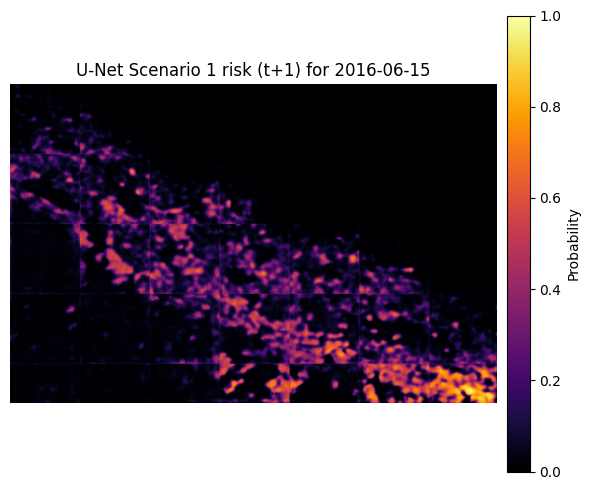

Saved risk PNG -> future_forecasts\unet_scenario1_prob_tplus1_2016-06-15.png


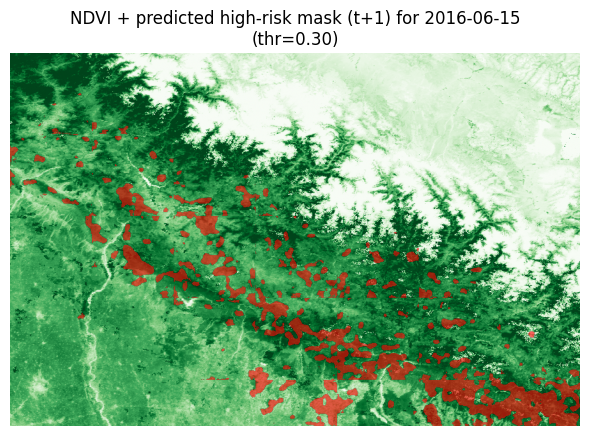

Saved overlay PNG -> future_forecasts\unet_scenario1_overlay_tplus1_2016-06-15.png


In [ ]:
import os, json, glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tensorflow import keras

if 'stack' not in globals() or 'UNET_FEATURE_IDXS' not in globals():
    raise SystemExit('`stack` or `UNET_FEATURE_IDXS` not found. Run the RF/data cell and U-Net config cell first.')

T, B, H, W = stack.shape

t_input = T - 1
if t_input < 0:
    raise SystemExit('Stack is empty; no days available for forecasting.')

date_str = dates[t_input] if 'dates' in globals() and len(dates) > t_input else f'index_{t_input}'

MODEL_DIR = MODEL_DIR if 'MODEL_DIR' in globals() else 'models'
model_path = os.path.join(MODEL_DIR, 'unet_scenario1_tplus1.keras')
meta_path = os.path.join(MODEL_DIR, 'unet_scenario1_tplus1_meta.json')

if not os.path.exists(model_path) or not os.path.exists(meta_path):
    raise SystemExit('Saved U-Net Scenario 1 model or meta JSON not found. Run the save-model cell after training first.')

unet_infer = keras.models.load_model(model_path, compile=False)

with open(meta_path, 'r') as f:
    meta = json.load(f)
best_thr_u_infer = float(meta.get('best_thr_u', 0.5))

feat_chw = stack[t_input, UNET_FEATURE_IDXS] 
C, H, W = feat_chw.shape

PATCH_SIZE_INFER = PATCH_SIZE if 'PATCH_SIZE' in globals() else 128

prob_full = np.zeros((H, W), dtype='float32')

for y0 in range(0, H, PATCH_SIZE_INFER):
    for x0 in range(0, W, PATCH_SIZE_INFER):
        y1 = min(y0 + PATCH_SIZE_INFER, H)
        x1 = min(x0 + PATCH_SIZE_INFER, W)

        sub = feat_chw[:, y0:y1, x0:x1]  
        h_sub = y1 - y0
        w_sub = x1 - x0

        pad_h = PATCH_SIZE_INFER - h_sub
        pad_w = PATCH_SIZE_INFER - w_sub

        if pad_h > 0 or pad_w > 0:
            sub = np.pad(
                sub,
                ((0, 0), (0, pad_h), (0, pad_w)),
                mode='constant',
                constant_values=0.0,
            )

        x_patch = np.transpose(sub, (1, 2, 0))[None, ...].astype('float32')

        y_pred = unet_infer.predict(x_patch, batch_size=1, verbose=0)[0, ..., 0]  

        prob_full[y0:y1, x0:x1] = y_pred[:h_sub, :w_sub]

prob_full = np.nan_to_num(prob_full, nan=0.0, posinf=1.0, neginf=0.0)
prob_full = np.clip(prob_full, 0.0, 1.0)
risk_mask = (prob_full >= best_thr_u_infer).astype('uint8')

OUT_DIR_FORECAST = 'future_forecasts'
os.makedirs(OUT_DIR_FORECAST, exist_ok=True)

stack_dir = OUTPUT_DIR_STACKS if 'OUTPUT_DIR_STACKS' in globals() else 'daily_stacks'
pattern = os.path.join(stack_dir, 'Uttarakhand_stack_*.tif')
stack_files = sorted(glob.glob(pattern))
profile = None
if stack_files and 0 <= t_input < len(stack_files):
    with rasterio.open(stack_files[t_input]) as src:
        profile = src.profile.copy()

if profile is not None:
   
    profile_prob = profile.copy()
    profile_prob.update(count=1, dtype='float32')
    out_prob_tif = os.path.join(OUT_DIR_FORECAST, f'unet_scenario1_prob_tplus1_{date_str}.tif')
    with rasterio.open(out_prob_tif, 'w', **profile_prob) as dst:
        dst.write(prob_full.astype('float32'), 1)


    profile_mask = profile.copy()
    profile_mask.update(count=1, dtype='uint8')
    out_mask_tif = os.path.join(OUT_DIR_FORECAST, f'unet_scenario1_mask_tplus1_{date_str}.tif')
    with rasterio.open(out_mask_tif, 'w', **profile_mask) as dst:
        dst.write(risk_mask.astype('uint8'), 1)

    print('Saved forecast GeoTIFFs to:', OUT_DIR_FORECAST)
    print('  Probabilities:', out_prob_tif)
    print('  Binary mask :', out_mask_tif)
else:
    print('GeoTIFF profile not found; saving only PNG previews.')

plt.figure(figsize=(6, 5))
im = plt.imshow(prob_full, cmap='inferno', vmin=0.0, vmax=1.0)
plt.title(f'U-Net Scenario 1 risk (t+1) for {date_str}')
plt.colorbar(im, fraction=0.046, pad=0.02, label='Probability')
plt.axis('off')
out_prob_png = os.path.join(OUT_DIR_FORECAST, f'unet_scenario1_prob_tplus1_{date_str}.png')
plt.tight_layout()
plt.savefig(out_prob_png, dpi=150)
plt.show()
print('Saved risk PNG ->', out_prob_png)

base_ndvi = None
try:
    base_ndvi = stack[t_input, B_NDVI]
    vmin_base = np.nanpercentile(base_ndvi, 5)
    vmax_base = np.nanpercentile(base_ndvi, 95)
except Exception:
    base_ndvi = None

if base_ndvi is not None:
    plt.figure(figsize=(6, 5))
    plt.imshow(base_ndvi, cmap='Greens', vmin=vmin_base, vmax=vmax_base)
    plt.imshow(np.ma.masked_where(risk_mask == 0, risk_mask), cmap='autumn', alpha=0.6)
    plt.title(f'NDVI + predicted high-risk mask (t+1) for {date_str}\n(thr={best_thr_u_infer:.2f})')
    plt.axis('off')
    out_overlay_png = os.path.join(OUT_DIR_FORECAST, f'unet_scenario1_overlay_tplus1_{date_str}.png')
    plt.tight_layout()
    plt.savefig(out_overlay_png, dpi=150)
    plt.show()
    print('Saved overlay PNG ->', out_overlay_png)